In [26]:
%matplotlib inline
import seaborn as sns; 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import gridspec
import scipy
style.use('ggplot')
import datetime
from io import StringIO
import re
import os
import numpy as np
from datetime import datetime
import apt_pkg
apt_pkg.init_system()
from tqdm import tqdm_notebook as tqdm

In [137]:
sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22
flatui = [sns.xkcd_rgb["medium green"], "orange", sns.xkcd_rgb["medium purple"], "#e74c3c", "#34495e", "#2ecc71"]

# First, we check if the latest version == highest version of a packages

# Load installed packages

In [4]:
packages = pd.read_csv('../../data/for_analysis/tlag.csv', usecols=['package'])
)
packages.drop_duplicates(inplace=True)
packages.shape

(3410, 1)

# Load Debian Packages

In [116]:
debian_packages = pd.read_csv('../../data/prepared_data/debian_packages.csv')
debian_packages.shape

(804645, 5)

In [8]:
debian_packages = debian_packages[debian_packages.package.isin(packages.package)]
len(debian_packages)

93293

In [9]:
debian_packages.package.unique().shape

(3410,)

In [12]:
debian_packages['archive'] = debian_packages['archive'].apply(lambda x: x.split('-')[0])

In [16]:
debian_packages.archive.unique()

array(['jessie', 'stretch', 'buster', 'bullseye'], dtype=object)

In [ ]:
for package in package.unique():
    for archive in debian_packages.archive.unique():
        package = "adduser"
        archive = "stretch"
        debian_packages.query('package =='++)

In [28]:
### Here we sort using the debian function
all_packages={}
for package in tqdm(debian_packages.package.unique()):
    all_packages[package]={}
    for archive in debian_packages.archive.unique():
        versions_all = debian_packages.query('package=="'+package+'" and archive=="'+archive+'"').version.unique()
        all_packages[package][archive]=[]
        a=[]
        for x in versions_all:
            ver=False
            for index, y in enumerate(a):
                if apt_pkg.version_compare(x,y) <0:
                    a=a[:index] + [x] + a[index:]
                    ver=True
                    break
            if not ver:
                a=a+[x]
        all_packages[package][archive]=a

df_all=pd.DataFrame()
for package in tqdm(debian_packages.package.unique()):
    for archive in debian_packages.archive.unique():
        temp=pd.DataFrame({'package':package, 
                           'archive':archive,
                           'version':all_packages[package][archive], 
                           'order':[u for u in range(len(all_packages[package][archive]))]})
        df_all=pd.concat([df_all,temp])

In [35]:
len(df_all), len(debian_packages)

(93293, 93293)

In [38]:
a = (df_all
          .merge(debian_packages, 
                on = ['package','version','archive'],
                how = 'left')
         )

In [60]:
version = (a
           .sort_values('order')
           .groupby(['package','archive'])
           .last()
           .reset_index()
           [['package','archive','version','order']]
          )
date = (a
        .sort_values('date')
        .groupby(['package','archive'])
        .last()
        .reset_index()
        [['package','archive','version','date']]

          )

In [68]:
a = (version
          .merge(date, 
                on = ['package','archive','version'],
                how = 'left')
         )
if len(a.dropna())/len(a) > 0.95:
    print('latest = highest')
    print(len(a.dropna())/len(a))
    print(len(a.dropna()), len(a))

latest = highest
0.9995962043206138
9902 9906


## It seems that 99.9% of packages have the latest version == the highest version 

# Let's check now if the package versions found installed in some specific distribution come from its corresponding archive (i.e. release == archive)

In [70]:
packages = pd.read_csv('../../data/for_analysis/installed_packages.csv',
                      usecols=['image','package','archive','release','last_updated'])
packages.shape

(46558282, 5)

In [73]:
packages['archive'] = packages['archive'].apply(lambda x: x.split('-')[0])

In [85]:
packages.release.unique()

array(['stretch', 'buster', 'jessie', 'undefined'], dtype=object)

In [86]:
archve_release = packages.query('archive != release and release != "undefined" and archive != "bullseye"')

In [87]:
len(archve_release)*100/len(packages)

1.3869605411986636

In [88]:
packages.image.unique().shape, archve_release.image.unique().shape
# 79893/140512 = 56.8%

((140512,), (79893,))

In [89]:
packages.query('release != "undefined" and archive != "bullseye"').image.unique().shape

(140498,)

### NUMBER OF USED IMAGES : 140,498

# Let's check how much time does it take before a bug is fixed, using survival analysis

In [117]:
def get_version(source, version):
    if '(' in source:
        return re.search(r'\((.*?)\)',source).group(1)
    else:
        return version
    
debian_packages['source_version'] = debian_packages.apply(lambda d: get_version(d['source'],d['version']), axis=1)
debian_packages['source'] = debian_packages['source'].apply(lambda x: x.split('(')[0].strip())
for col in debian_packages.columns:
    debian_packages[col] = debian_packages[col].apply(str)
debian_packages['date'] = debian_packages['date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])

In [118]:
debian_packages.head(2)

,package,version,archive,date,source,source_version
0,0ad,0.0.13-1,jessie,2013-05-06,0ad,0.0.13-1
1,0ad,0.0.13-2,jessie,2013-06-04,0ad,0.0.13-2


In [125]:
bugs = pd.read_csv('../../data/prepared_data/bugs.csv')
bugs.shape

(414547, 10)

In [126]:
bugs = bugs[['debianbug','source','found_in','arrival','status','severity','type']].drop_duplicates()

In [127]:
bugs.rename(columns ={'found_in':'source_version'}, inplace=True)

In [128]:
bugs = (bugs
       .merge(debian_packages[['source','source_version','date']].drop_duplicates(),
              on = ['source','source_version'],
              how = 'left'
       ))
bugs.shape

(51439, 8)

In [130]:
bugs = bugs.dropna()
bugs.shape

(34407, 8)

In [149]:
arrival_before = bugs.query('arrival<date')
arrival_after = bugs.query('arrival>=date')
len(arrival_before), len(arrival_after)

(5568, 28839)

In [143]:
arrival_after.head(2)

,debianbug,source,source_version,arrival,status,severity,type,date
13468,706918,ppp,2.4.5-5.1,2013-05-06,pending,normal,normal,2013-05-06
13472,706979,pidgin-libnotify,0.14-9,2013-05-06,pending,normal,normal,2013-05-06


In [133]:
arrival_after['severity']=arrival_after['severity'].apply(lambda x:
                                                     'high' if x=="grave"
                                                     else 'high' if x=="serious"
                                                     else 'high' if x=="critical"
                                                     else x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [150]:
arrival_after['arrival']= pd.to_datetime(arrival_after['arrival'])
arrival_after['date']=pd.to_datetime(arrival_after['date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


minor 4.0
serious 8.0
grave 17.0
critical 3.9
important 3.4
normal 3.466666666666667


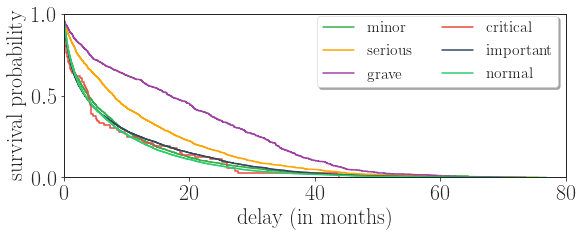

In [155]:
import lifelines
from lifelines.statistics import logrank_test
fig, ax = plt.subplots()

kmp_df = (
    arrival_after[['debianbug', 'arrival','severity','date']]
    .assign(duration=lambda d: (d['arrival'] - d['date']).dt.days / 30)
)

PALETTE = sns.color_palette(flatui)[:6] 
PALETTE_2 = sns.color_palette('Set3')[::-1]

kmp = lifelines.KaplanMeierFitter()
data = []
for i, severity in enumerate(['minor','serious','grave','critical','important','normal']):
#for i, severity in enumerate(['minor','high','important','normal']):

    mask = kmp_df['severity'] == severity
    kmp.fit(kmp_df[mask]['duration'], label=severity)
    print(severity, kmp.median_)
    kmp.plot(ax=ax, ci_show=False, color=PALETTE[i])

ax.set(
    xlim=(0, 80),
    xlabel='delay (in months)',
    ylim=(0, 1),
    ylabel='survival probability',
)
ax.figure.set_size_inches(9,3)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.04), fontsize=15.5, fancybox=True, shadow=True,ncol=2)
